<a href="https://colab.research.google.com/github/ArmandoLp/AprendizajeMaquina-Profundo/blob/main/Tarea_1_Redes_densas_J_Armando_Lopez_V.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Red de unidades de umbral lineal
Programa y evalúa una red de neuronas con funciones de activación escalón unitario que aproxime la operación XNOR (⊙)


In [ ]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from sklearn import datasets

Primero programamos la función que nos convertirá la salida en una salida binaria, esto es:

$
\phi(x) = \begin{cases} 1, \text{si } x>0 \\0,  \text{en caso contrario}\end{cases}
$

In [ ]:
def escalon(z):
  if z>0.0:
    return 1.0
  else:
    return 0.0

Ahora, programaremos la función que computa la suma de los pesos multiplicados por las entradas, esto es:

$
z = w_1 \cdot x_1 + w_2 \cdot x_2 + \cdots + w_d \cdot x_d + b 
$

In [ ]:
def neurona(x, w, b):
  z = np.dot(w.T, x) + b
  a = escalon(z)

  return a

Ahora bien, debemos tener en cuenta que tipo de "compuerta lógica" utiliza la función XNOR, cuya función es la inversa a la OR exclusiva, esto es:

![image.png](https://upload.wikimedia.org/wikipedia/commons/thumb/f/f8/XNOR_using_NOR.svg/450px-XNOR_using_NOR.svg.png)

La cual se puede expresar por:
$
{\displaystyle A\cdot B+{\overline {A}}\cdot {\overline {B}}}={\displaystyle {\overline {A\oplus B}}}. $

Por lo que necesitamos la compuerta AND, OR, NOT

Cuya salida es:

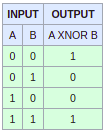


Ahora bien, para computar XNOR utilizaremos los pesos conocidos en la clase, de esta manera, la función xnor_red lo que busca es unir ambas salidas para utilizar ambos pesos y así poder modelar la compuerta XNOR

In [ ]:
def xnor_red(X, W1, b1, W2, b2):
  escv = np.vectorize(escalon)
  a = escv(np.dot(W1.T, X) + b1)
  return escv(np.dot(W2.T, a) + b2)

In [ ]:
y = np.array([1., 0., 0., 1.]) #Salida real
X = np.array([[0., 0.], [0., 1.], [1., 0.], [1., 1.]])


#pesos para and
W1 = np.array([[10, -10], [10, -10]]) 
b1 = np.array([-15, 5])

#pesos para or
W2 = np.array([[10], [10]]) # OR
b2 = np.array([-5])

print('W_1 = [{0}{1}], b_1 = {2}'.format(W1[0, :], W1[1, :], b1))
print('W_2 = [{0}{1}], b_2 = {2}'.format(W2[0], W2[1], b2))
print('-----------------------------')
print('A \tB \ty\ty_predicted')
print('-----------------------------')
for i in range(X.shape[0]):
  y_hat = xnor_red(X[i], W1, b1, W2, b2)
  print('{0}\t{1}\t{2}\t{3}'.format(X[i, 0], X[i, 1], y[i], y_hat[0]))

W_1 = [[ 10 -10][ 10 -10]], b_1 = [-15   5]
W_2 = [[10][10]], b_2 = [-5]
-----------------------------
A 	B 	y	y_predicted
-----------------------------
0.0	0.0	1.0	1.0
0.0	1.0	0.0	0.0
1.0	0.0	0.0	0.0
1.0	1.0	1.0	1.0


## 2. Retropropagación en red densa

Programa el algoritmo de retropropagación usando NumPy para una tarea de clasificación binaria presuponiendo una red densa con dos capas ocultas y la función de pérdida de entropía cruzad binaria. Describe las fórmulas y reglas de actualización de los pesos y sesgos de cada capa y entrena y evalúa la red en algún conjunto de datos.

In [ ]:
import numpy as np


Utilizaremos el conjunto de datos del ejercicio anterior (XNOR) la cual tiene dos atributos (A,B) y una salida (A XNOR B) que llamaremos y, dado que la tarea es binaria, la salida pasará por una función de activación sigmoide la cual es:

$$
\sigma(z) = \frac{1}{1 + e^{-z}}
$$

que se programa a continuación:

In [ ]:
def sigmoide(z):
  return 1/ (1+np.exp(-z))

Dado que haremos backprop necesitamos conocer la dereivada para propagar el error, utilizaremos la definición vista en clase de la derivada utilizando la función, es decir:

$$
\frac{\partial \sigma (z)}{\partial z} = \sigma(z) (1 - \sigma(z))
$$

In [ ]:
def derivada_sigmoide(x):
  return np.multiply(sigmoide(x), (1.0 - sigmoide(x)))

Falta realizar la función de pérdida, a petición de la tarea, la función será la pérdida de entropía cruzada binaria, la cual se define:

$$
ECB(\mathbf{y}, \mathbf{\hat{y}})  = -\sum_{i=1}^N \left[ y^{(i)} \log \hat{y}^{(i)} + (1 - y^{(i)}) \log (1 - \hat{y}^{(i)}) \right]
$$

In [ ]:
def entropia_cruzada_binaria(y, p):
    p[p == 0] = np.nextafter(0., 1.)
    p[p == 1] = np.nextafter(1., 0.)
    return -(np.log(p[y == 1]).sum() + np.log(1 - p[y == 0]).sum())

In [ ]:
#Computamos el accuracy
def accuracy(y, y_pred):
    return (y == y_pred).mean() * 100



Siguiendo el flujo del notebook visto en clase, procedemos a definir la función de propagación hacia adelante. Notemos que al tener dos capas ocultas entonces tenemos 3 matrices de pesos con 3 sesgos, por lo cual la propagación se desarrolla así:

$$
    \begin{split}
                \mathbf{a}^{\{1\}}  &=  \mathbf{x}^{(i)} \\
                \mathbf{z}^{\{2\}}  &=  \mathbf{W}^{\{1\}} \cdot \mathbf{a}^{\{1\}} + \mathbf{b}^{\{1\}}\\
                \mathbf{a}^{\{2\}}  &=  \sigma(\mathbf{z}^{\{2\}}) \\
                \mathbf{z}^{\{3\}}  &=  \mathbf{W}^{\{2\}} \cdot \mathbf{a}^{\{2\}}  + \mathbf{b}^{\{2\}}\\
                \mathbf{a}^{\{3\}}  &=  \sigma(\mathbf{z}^{\{3\}})\\
                 \mathbf{z}^{\{4\}}  &=  \mathbf{W}^{\{3\}} \cdot \mathbf{a}^{\{3\}}  + \mathbf{b}^{\{3\}}\\
                \mathbf{a}^{\{4\}}  &=  \sigma(\mathbf{z}^{\{4\}})\\
                \hat{y}^{(i)}  &=  \mathbf{a}^{\{4\}}
            \end{split}
      $$

In [ ]:
def fordward(x, W1, b1, W2, b2, W3, b3):
    z2 = np.dot(W1.T, x[:, np.newaxis]) + b1
    a2 = sigmoide(z2)

    z3 = np.dot(W2.T, a2) + b2
    a3= sigmoide(z3)

    z4 = np.dot(W3.T, a3) + b3

    y_hat = sigmoide(z4)
    return z2, a2, z3, a3, z4, y_hat

Ahora definimos el backprop

In [ ]:
def back(X, y, alpha = 0.01, n_epocas = 100, n_ocultas=10):
    n_ejemplos = X.shape[0]
    n_entradas = X.shape[1]
        
    # Inicialización de las matrices de pesos W y V
    W1 = np.sqrt(1.0 / n_entradas) * np.random.randn(n_entradas, n_ocultas)
    b1 = np.zeros((n_ocultas, 1))

    W2 = np.sqrt(1.0 / n_ocultas) * np.random.randn(n_ocultas, n_ocultas)
    b2 = np.zeros((n_ocultas, 1))
    
    W3 = np.sqrt(1.0 / n_ocultas) * np.random.randn(n_ocultas, 1)
    b3 = np.zeros((1, 1))
    
    perdidas = np.zeros((n_epocas))
    exactitudes = np.zeros((n_epocas))
    y_predicha = np.zeros((y.shape))
    for i in range(n_epocas):
        for j in range(n_ejemplos):
            z2, a2, z3, a3, z4, y_hat = fordward(X[j], W1, b1, W2, b2, W3, b3)

            # cálculo de gradientes para W3 y b3 por retropropagación
            dz4 = y_hat - y[j]
            dW3 = np.outer(a3, dz4)
            db3 = dz4

            # cálculo de gradientes para W1 y b1 por retropropagación
            dz3 = np.dot(W3, dz4) * derivada_sigmoide(z3)
            dW2 = np.outer(a2, dz3)
            db2 = dz3

            # cálculo de gradientes para W1 y b1 por retropropagación
            dz2 = np.dot(W2, dz3) * derivada_sigmoide(z2)
            dW1 = np.outer(X[j], dz2)
            db1 = dz2
            
            ####################################
            # IMPORTANTE 
            # la actualización de los parámetros
            # debe hacerse de forma simultánea
            W3 = W3 - alpha * dW3
            b3 = b3 - alpha * db3 

            W2 = W2 - alpha * dW2
            b2 = b2 - alpha * db2
            
            W1 = W1 - alpha * dW1
            b1 = b1 - alpha * db1

            y_predicha[j] = y_hat
            
        # calcula la pérdida en la época
        perdidas[i] = entropia_cruzada_binaria(y, y_predicha)
        exactitudes[i] = accuracy(y, np.round(y_predicha))
        print('Epoch {0}: Pérdida = {1} Exactitud = {2}'.format(i, 
                                                              perdidas[i], 
                                                              exactitudes[i]))

    return W1, W2, W3, perdidas, exactitudes

Ahora probamos para la operación del ejercicio anterior

In [ ]:
X = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y = np.array([[1, 0, 0, 1]]).T

In [ ]:

np.random.seed(0)
W1, W2, W3, perdidas, exactitudes = back(X, y, alpha = 1.5,  n_epocas = 800, n_ocultas = 10)

Epoch 0: Pérdida = 6.2413316609868215 Exactitud = 50.0
Epoch 1: Pérdida = 4.168668153230488 Exactitud = 50.0
Epoch 2: Pérdida = 3.9363415529090844 Exactitud = 50.0
Epoch 3: Pérdida = 3.8530745113603837 Exactitud = 50.0
Epoch 4: Pérdida = 3.806534414660276 Exactitud = 50.0
Epoch 5: Pérdida = 3.7767220000880624 Exactitud = 50.0
Epoch 6: Pérdida = 3.755877703246483 Exactitud = 50.0
Epoch 7: Pérdida = 3.7404086308475897 Exactitud = 50.0
Epoch 8: Pérdida = 3.728423419362137 Exactitud = 50.0
Epoch 9: Pérdida = 3.7188297162908053 Exactitud = 50.0
Epoch 10: Pérdida = 3.710951358033431 Exactitud = 50.0
Epoch 11: Pérdida = 3.7043467210760457 Exactitud = 50.0
Epoch 12: Pérdida = 3.698714749853549 Exactitud = 50.0
Epoch 13: Pérdida = 3.6938429084841253 Exactitud = 50.0
Epoch 14: Pérdida = 3.6895767165223674 Exactitud = 50.0
Epoch 15: Pérdida = 3.685801086076321 Exactitud = 50.0
Epoch 16: Pérdida = 3.6824284418810285 Exactitud = 50.0
Epoch 17: Pérdida = 3.6793909077450557 Exactitud = 50.0
Epoch 18:

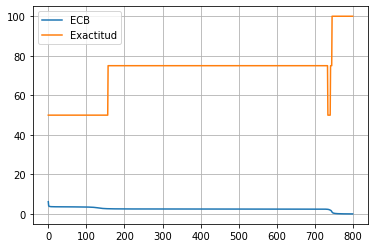

In [ ]:
import matplotlib.pyplot as plt
plt.plot(np.arange(perdidas.size), perdidas, label='ECB')
plt.plot(np.arange(exactitudes.size), exactitudes, label='Exactitud')
plt.legend()
plt.grid(True)
plt.show()

Como podemos ver, entre las 150 y 700 épocas la red entra en un mínimo local, después de eso ya obtenems la mejor exactitud en la red. Me di cuenta de que podía usar más épocas (inicialmente usé 100) ya que me di cuenta que la pérdida no dejaba de bajar, por lo que al probar con una cantidad enorme (2000) me di cuenta que estaba atorado en un mínimo o que algún parámetro me hacía acercarme lento al mínimo global

## 3. Regresión lineal con PyTorch
Entrena y evalúa un modelo de regresión lineal para el conjunto de datos de calificaciones que considere los dos atributos de entrada.

Grafica los datos en 3D.
Realiza la definición de la arquitectura usando tanto la interfaz de alto como la de medio nivel.
Prueba distintos valores para los hiperparámetros.
Realiza una predicción con tu modelo entrenado para la calificación que tendría un alumno si sabemos que estudió durante 12 horas para el examen y en un examen previo obtuvo 3 de calificación.
Discute las modificaciones que realizaste y las distintas configuraciones para los hiperparámetros que probaste.

In [ ]:
# sistema de archivos
import os
# tomar n elementos de una secuencia
from itertools import islice as take

# gráficas
import matplotlib.pyplot as plt
# arreglos multidimensionales
import numpy as np
# csv
import pandas as pd

# redes neuronales
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets.utils as vutils

from torch.utils.data import DataLoader
from torchvision.datasets.utils import download_url


# directorio de datos
URL = 'https://raw.githubusercontent.com/gibranfp/CursoAprendizajeProfundo/master/data/califs/califs.csv'
base_dir = '../data/califs/'
filename = 'califs.csv'
filepath = os.path.join(base_dir, 'califs.csv')

# para reproducibilidad
SEED = 0
torch.manual_seed(SEED)

In [ ]:
download_url(URL, base_dir, filename)

In [ ]:

df = pd.read_csv(filepath, names=['calif anterior','horas de estudio','calificación'])
df.head(5)

,calif anterior,horas de estudio,calificación
0,5.638,8.289,5.136
1,6.744,9.389,5.931
2,5.136,10.060,5.484
3,5.748,10.421,6.524
4,7.136,10.434,6.770


### Grafica los datos en 3D.

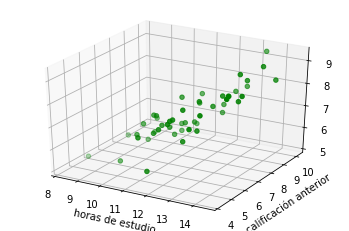

In [ ]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt

# Creamos la figura
fig = plt.figure()
# Creamos el plano 3D
ax1 = fig.add_subplot(111, projection='3d')
# Agregamos los puntos en el plano 3D
ax1.scatter(df.iloc[:,1], df.iloc[:,0], df.iloc[:,-1], c='g', marker='o')

# Mostramos el gráfico
plt.xlabel('horas de estudio')
plt.ylabel('calificación anterior')
plt.show()

In [ ]:
x_trn = np.array(df.iloc[:,:2], dtype="float32")
# se obtiene la salda
y_trn = np.array(df.iloc[:,-1], dtype="float32")[..., np.newaxis]

In [ ]:
class CalifDS:
    
    def __init__(self, X, Y):
        self.x = X
        self.y = Y

    def __getitem__(self, i):
        return self.x[i], self.y[i]

    def __len__(self):
        return len(self.y)

In [ ]:
batch_size = 16

# creamos un Dataset
ds = CalifDS(x_trn, y_trn)

# creamos un DataLoader
trn_dl = DataLoader(ds, batch_size=batch_size, shuffle=True)

# desplegamos un lote de ejemplos
for x, y in take(trn_dl, 1):
    print(f'x shape={x.shape} dtype={x.dtype}')
    print(f'y shape={y.shape} dtype={y.dtype}')

x shape=torch.Size([16, 2]) dtype=torch.float32
y shape=torch.Size([16]) dtype=torch.float32


In [ ]:
len(ds)

50

### Realiza la definición de la arquitectura usando tanto la interfaz de alto como la de medio nivel.

## Alto nivel

In [ ]:
model = nn.Sequential(
  nn.Linear(2,1)
)
print(model)


Sequential(
  (0): Linear(in_features=2, out_features=1, bias=True)
)


In [ ]:

# optimizador
opt = optim.SGD(model.parameters(), lr=1e-3)

# historial de pérdida
loss_hist = []

# ciclo de entrenamiento
EPOCHS = 30
for _ in range(EPOCHS):

    # entrenamiento de una época
    for x, y_true in trn_dl:
        # hacemos inferencia para obtener los logits
        y_lgts = model(x)
        # calculamos de pérdida
        loss = F.mse_loss(y_lgts, y_true)
        # vaciamos los gradientes
        opt.zero_grad()
        # retropropagamos
        loss.backward()
        # actulizamos parámetros
        opt.step()
        
        # guardamos historial de pérdida
        loss_hist.append(loss.item() * 100)

#print(loss_hist)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


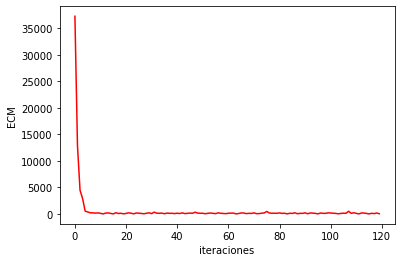

In [ ]:
plt.plot(loss_hist, color='red')
plt.xlabel('iteraciones')
plt.ylabel('ECM');

In [ ]:
x_trn[:,1]

array([ 8.289,  9.389, 10.06 , 10.421, 10.434, 10.437, 10.46 , 10.518,
       10.768, 10.948, 10.964, 11.207, 11.366, 11.508, 11.525, 11.539,
       11.555, 11.596, 11.611, 11.784, 11.864, 11.896, 11.915, 11.937,
       11.949, 11.971, 12.026, 12.111, 12.164, 12.276, 12.524, 12.803,
       12.807, 12.814, 12.818, 12.865, 12.943, 12.961, 13.026, 13.12 ,
       13.325, 13.373, 13.433, 13.577, 13.739, 13.745, 13.821, 13.99 ,
       13.992, 14.45 ], dtype=float32)

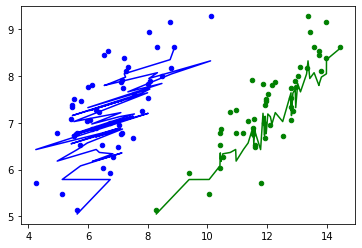

In [ ]:
x_train = torch.from_numpy(x_trn)

with torch.no_grad():
    y_pred = model(x_train).numpy()

plt.plot(x_trn[:,0], y_trn, '.', color='blue', markersize=9)
plt.plot(x_trn[:,0], y_pred, color='blue')
plt.plot(x_trn[:,1], y_trn, '.', color='green', markersize=9)
plt.plot(x_trn[:,1], y_pred, color='green')

#No supe como hacer la linea de la regresion en 3d :'v

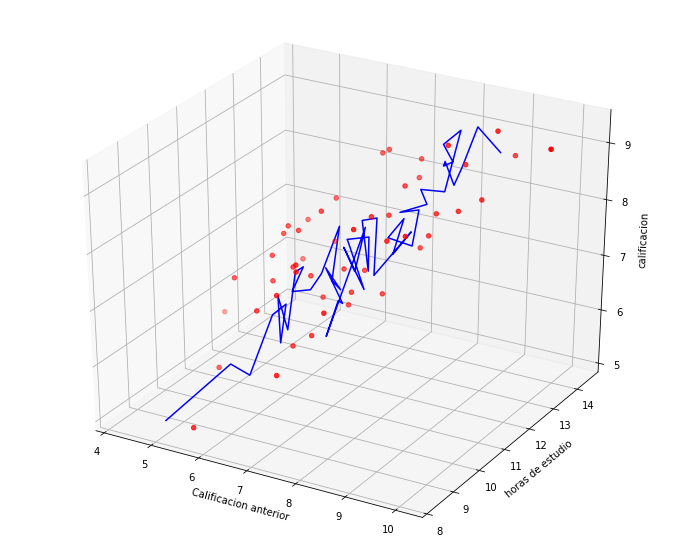

In [ ]:
#ya supe :B
x_train = torch.from_numpy(x_trn)

with torch.no_grad():
    y_pred = model(x_train).numpy()

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

for c, m in [('r', 'o')]:
  x_cal = np.array(df.iloc[:,0], dtype="float32")
  x_hr = np.array(df.iloc[:,1], dtype="float32")
  y_trn = np.array(df.iloc[:,-1], dtype="float32")
  ax.scatter(x_cal, x_hr, y_trn, c=c, marker=m)
  ax.plot3D(y_pred, x_hr, y_trn, 'blue')


ax.set_xlabel('Calificacion anterior')
ax.set_ylabel('horas de estudio')
ax.set_zlabel('calificacion')
plt.show()

Hacemos una predicción de alto nivel.

In [ ]:

x = torch.tensor([[3, 12.0]])

# deshabilitamos el rastreo de gradientes
with torch.no_grad():
    y_pred = model(x).numpy()

print("La calificación será:", y_pred[0][0])

La calificación será: 6.2837477


Por lo que según el modelo, si reprobaste este examen, pero estudias lo suficiente para el siguiente, puedes pasar con 6 ;)


### Medio nivel

In [ ]:

#se define la clase RegLin que hereda de torch.nn.Module
class RegLin(nn.Module):

    #se define el inicializador
    def __init__(self):
        # se llama al inicializador de la clase padre
        super(RegLin, self).__init__()
        # importante: se definen las capas como atributos de la clase
        self.fc = nn.Linear(2, 1)

    # método para inferencia
    def forward(self, x):
        # definición de arquitectura 
        return self.fc(x)

model = RegLin()

In [ ]:

# optimizador
opt = optim.SGD(model.parameters(), lr=1e-3)

# historial de pérdida
loss_hist = []

# ciclo de entrenamiento
EPOCHS = 30
for _ in range(EPOCHS):

    # entrenamiento de una época
    for x, y_true in trn_dl:
        # hacemos inferencia para obtener los logits
        y_lgts = model(x)
        # calculamos de pérdida
        loss = F.mse_loss(y_lgts, y_true)
        # vaciamos los gradientes
        opt.zero_grad()
        # retropropagamos
        loss.backward()
        # actulizamos parámetros
        opt.step()
        
        # guardamos historial de pérdida
        loss_hist.append(loss.item() * 100)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


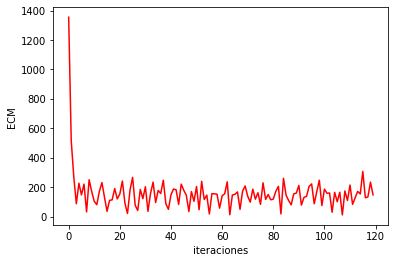

In [ ]:
plt.plot(loss_hist, color='red')
plt.xlabel('iteraciones')
plt.ylabel('ECM');

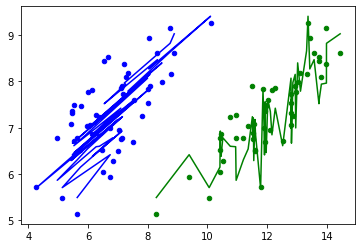

In [ ]:
x_train = torch.from_numpy(x_trn)

with torch.no_grad():
    y_pred = model(x_train).numpy()

plt.plot(x_trn[:,0], y_trn, '.', color='blue', markersize=9)
plt.plot(x_trn[:,0], y_pred, color='blue')
plt.plot(x_trn[:,1], y_trn, '.', color='green', markersize=9)
plt.plot(x_trn[:,1], y_pred, color='green')

#No supe como hacer la linea de la regresion en 3d :'v

In [ ]:

x = torch.tensor([[3, 12.0]])

# deshabilitamos el rastreo de gradientes
with torch.no_grad():
    y_pred = model(x).numpy()

print("La calificación será:", y_pred[0][0])

La calificación será: 5.0518975




### Prueba distintos valores para los hiperparámetros.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  app.launch_new_instance()


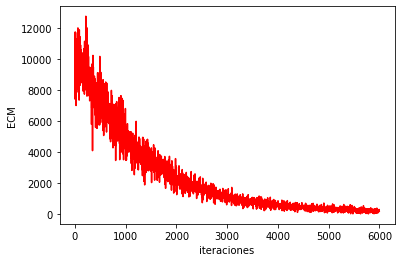

In [ ]:
model = RegLin()
opt = optim.SGD(model.parameters(), lr=1e-6)

# historial de pérdida
loss_hist = []

# ciclo de entrenamiento
EPOCHS = 1500
for _ in range(EPOCHS):

    # entrenamiento de una época
    for x, y_true in trn_dl:
        # hacemos inferencia para obtener los logits
        y_lgts = model(x)
        # calculamos de pérdida
        loss = F.mse_loss(y_lgts, y_true)
        # vaciamos los gradientes
        opt.zero_grad()
        # retropropagamos
        loss.backward()
        # actulizamos parámetros
        opt.step()
        
        # guardamos historial de pérdida
        loss_hist.append(loss.item() * 100)
plt.plot(loss_hist, color='red')
plt.xlabel('iteraciones')
plt.ylabel('ECM');

In [ ]:
x = torch.tensor([[3, 12.0]])

# deshabilitamos el rastreo de gradientes
with torch.no_grad():
    y_pred = model(x).numpy()

print("La calificación será:", y_pred[0][0])

La calificación será: 4.620241


### Discusión.

Después de hacer bastantes combinaciones, encontré que el learning rate = 1e-6 funcionaba "bien" debido a que el resto era bastante ruidoso y fluctuante. La cantidad de épocas lo dejé demasiado grande para que se pudiese ver el codo, sin embargo está demasiado ruidoso, esto se puede deber a distintos factores, uno de ellos, a mi parecer el más importante es la cantidad de ejemplos que se tienen, por eso le cuesta trabajo, además de ser sólo una regresión, no puede modelar de manera adecuada la relación entre los atributos y la variable a predecir. Ya que al tener tan pocos ejemplos, los ve demasiadas veces y en cada iteración se ajusta para esa vista, sin embargo se desajusta para otra, por lo que resulta difícil aprender la relación entre los atributos







## 4. Red completamente conectada con Pytorch
Implementa una red completamente conectada para la tarea de clasificación de imágenes sobre el conjunto de Fashion-MNIST, tomando en cuenta las siguiente especificaciones:



*   Explora con diferentes número de neuronas, capas, funciones de activación e hiperparámetros.
*   Discute tus resultados con las distintas configuraciones.


In [ ]:
!pip install torch-summary

Utilizaremos la libreta que vimos en clase anotando las respectivas modificaciones que se tienen que realizar para que funcione con este nuevo dataset

In [ ]:
# funciones aleatorias
import random
# tomar n elementos de una secuencia
from itertools import islice as take

# gráficas
import matplotlib.pyplot as plt
# arreglos multidimensionales
import numpy as np
# redes neuronales
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# imágenes
from skimage import io
# redes neuronales
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import FashionMNIST #<<<<<<<<<<<<<<<<<<<<<<<<<El nuevo dataset
# inspección de arquitectura
# https://github.com/TylerYep/torch-summary
from torchsummary import summary
# barras de progreso
from tqdm import tqdm

# directorio de datos
DATA_DIR = '../data'

# MNIST
MEAN = (0.1307)
STD = (0.3081)

# tamaño del lote
BATCH_SIZE = 128

# reproducibilidad
SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

In [ ]:
def display_grid(xs, titles, rows, cols):
    fig, ax = plt.subplots(rows, cols)
    for r in range(rows):
        for c in range(cols):
            i = r * rows + c
            ax[r, c].imshow(xs[i], cmap='gray')
            ax[r, c].set_title(titles[i])
            ax[r, c].set_xticklabels([])
            ax[r, c].set_yticklabels([])
    fig.tight_layout()
    plt.show()

In [ ]:
# creamos un Dataset
ds = FashionMNIST(
    # directorio de datos
    root=DATA_DIR, 
    # subconjunto de entrenamiento
    train=True, 
    # convertir la imagen a ndarray
    transform=np.array, 
    # descargar el conjunto
    download=True
)

images[0] shape=(28, 28) dtype=uint8


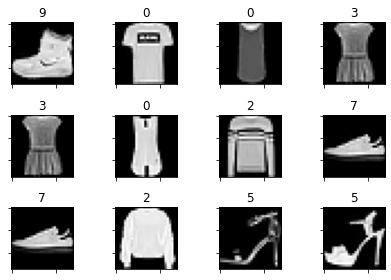

In [ ]:
images, labels = [], []
for i in range(12):
    x, y = ds[i]
    images.append(x)
    labels.append(y)

# desplegamos
print(f'images[0] shape={images[0].shape} dtype={images[0].dtype}')
titles = [str(y) for y in labels]
display_grid(images, titles, 3, 4)

Como podemos ver, las imagenes del dataset son prendas de ropa en escala de grises

In [ ]:
ds.classes
#¿Cuántas clases tenemos?

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

### Entrenamiento

In [ ]:
# transformaciones para la imagen
trn_tsfm = transforms.Compose([
    # convertimos a torch.Tensor y escalamos a [0,1]
    transforms.ToTensor(),
    # estandarizamos: restamos la media y dividimos sobre la varianza
    transforms.Normalize(MEAN, STD),
])

# creamos un Dataset
trn_ds = FashionMNIST(
    # directorio de datos
    root=DATA_DIR,
    # subconjunto de entrenamiento
    train=True,
    # transformación
    transform=trn_tsfm
)

# creamos un DataLoader
trn_dl = DataLoader(
    # conjunto
    trn_ds,
    # tamaño del lote
    batch_size=BATCH_SIZE,
    # desordenar
    shuffle=True
)

# desplegamos un lote de imágenes
for x, y in take(trn_dl, 1):
    print(f'x shape={x.shape} dtype={x.dtype}')
    print(f'y shape={y.shape} dtype={y.dtype}')


x shape=torch.Size([128, 1, 28, 28]) dtype=torch.float32
y shape=torch.Size([128]) dtype=torch.int64


### Prueba
Ahora creamos los conjuntos de prueba

In [ ]:
tst_tsfm = transforms.Compose([
    # convertimos a torch.Tensor y escalamos a [0,1]
    transforms.ToTensor(),
    # estandarizamos: restamos la media y dividimos sobre la varianza
    transforms.Normalize(MEAN, STD),
])

# creamos un Dataset
tst_ds = FashionMNIST(
    # directorio de datos
    root=DATA_DIR, 
    # subconjunto de entrenamiento
    train=False,
    # transformación
    transform=tst_tsfm
)

# creamos un DataLoader
tst_dl = DataLoader(
    # subconjunto
    tst_ds,
    # tamaño del lote
    batch_size=BATCH_SIZE,
    # desordenar
    shuffle=True
)

# imprimimos forma y tipo del lote
for x, y in take(tst_dl, 1):
    print(f'x shape={x.shape} dtype={x.dtype}')
    print(f'y shape={y.shape} dtype={y.dtype}')

x shape=torch.Size([128, 1, 28, 28]) dtype=torch.float32
y shape=torch.Size([128]) dtype=torch.int64


In [ ]:
x.shape

torch.Size([128, 1, 28, 28])

### Definición de la arquitectura

In [ ]:
class MLP(nn.Module):
    
    # inicializador
    def __init__(self):
        # inicilización del objeto padre, obligatorio
        super(MLP, self).__init__()
        # tamaño de las capas
        self.I = 1 * 28 * 28
        FC1, FC2 = 128, 10
        # definición de capas
        self.cls = nn.Sequential(
            # fc1
            # [N, 1x28x28] => [N, 128]
            
            nn.Linear(self.I, FC1),
            nn.ReLU(),
            # fc2
            # [N, 128] => [N, 10]
            nn.Linear(FC1, FC2)
        )
    
    # metodo para inferencia
    def forward(self, x):
        # aplanamos los pixeles de la imagen
        # [N, 1, 28, 28] => [N, 1x28x28]
        x = x.view(-1, self.I)
        # inferencia
        # [N, 1x28x28]
        x = self.cls(x)
        return x


In [ ]:
model= MLP()
summary(model, (1, 28, 28), device='cpu', verbose=0)


Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 10]                  --
|    └─Linear: 2-1                       [-1, 128]                 100,480
|    └─ReLU: 2-2                         [-1, 128]                 --
|    └─Linear: 2-3                       [-1, 10]                  1,290
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
Total mult-adds (M): 0.20
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.39
Estimated Total Size (MB): 0.39

Como podemos ver, estamos usando la misma arquitectura que utilizó Bere en la clase

### Entrenamiento

In [ ]:
# optimizador
opt = optim.SGD(model.parameters(), lr=1e-3)
# historial de pérdida
loss_hist = []

# ciclo de entrenamiento
EPOCHS = 20
for epoch in range(EPOCHS):
    
    # entrenamiento de una época
    for x, y_true in trn_dl:
        # vaciamos los gradientes
        opt.zero_grad()
        # hacemos inferencia para obtener los logits
        y_lgts = model(x)
        # calculamos la pérdida
        loss = F.cross_entropy(y_lgts, y_true)
        # retropropagamos
        loss.backward()
        # actulizamos parámetros
        opt.step()

    # evitamos que se registren las operaciones 
    # en la gráfica de cómputo
    with torch.no_grad(): 
        # modelo en modo de evaluación
        model.eval()
        
        losses, accs = [], []
        # validación de la época
        for x, y_true in take(tst_dl, 10):
            # hacemos inferencia para obtener los logits
            y_lgts = model(x)
            # calculamos las probabilidades
            y_prob = F.softmax(y_lgts, 1)
            # obtenemos la clase predicha
            y_pred = torch.argmax(y_prob, 1)
            
            # calculamos la pérdida
            loss = F.cross_entropy(y_lgts, y_true)
            # calculamos la exactitud
            acc = (y_true == y_pred).type(torch.float32).mean()

            # guardamos históricos
            losses.append(loss.item() * 100)
            accs.append(acc.item() * 100)

        # imprimimos métricas
        loss = np.mean(losses)
        acc = np.mean(accs)
        print(f'E{epoch:2} loss={loss:6.2f} acc={acc:.2f}')
        
        # agregagmos al historial de pérdidas
        loss_hist.append(loss)
        
        # modelo en modo de entrenamiento
        model.train()


E 0 loss=124.74 acc=64.14
E 1 loss= 95.31 acc=68.59
E 2 loss= 82.08 acc=73.75
E 3 loss= 76.73 acc=74.45
E 4 loss= 71.89 acc=75.86
E 5 loss= 65.81 acc=78.12
E 6 loss= 65.71 acc=78.52
E 7 loss= 63.65 acc=78.91
E 8 loss= 63.23 acc=78.05
E 9 loss= 60.37 acc=78.98
E10 loss= 61.14 acc=79.45
E11 loss= 56.61 acc=81.72
E12 loss= 56.75 acc=80.78
E13 loss= 51.23 acc=82.42
E14 loss= 54.58 acc=80.39
E15 loss= 52.44 acc=80.94
E16 loss= 53.52 acc=81.41
E17 loss= 51.07 acc=82.34
E18 loss= 51.86 acc=80.86
E19 loss= 53.40 acc=82.19


Estos son los resutlados utilizando los mismos parámetros vistos en clase, procedemos a hacer la variación

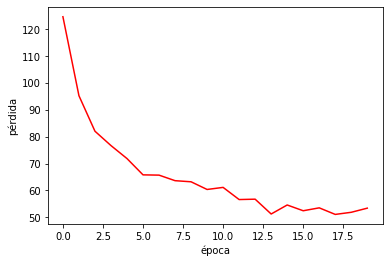

In [ ]:
plt.plot(loss_hist, color='red')
plt.xlabel('época')
plt.ylabel('pérdida')
plt.show()

A continuación probamos misma arquitectura cambiando nadamás el lr

In [ ]:
model = MLP()

# optimizador
opt = optim.SGD(model.parameters(), lr=1e-2)
# historial de pérdida
loss_hist = []

# ciclo de entrenamiento
EPOCHS = 40
for epoch in range(EPOCHS):
    
    # entrenamiento de una época
    for x, y_true in trn_dl:
        # vaciamos los gradientes
        opt.zero_grad()
        # hacemos inferencia para obtener los logits
        y_lgts = model(x)
        # calculamos la pérdida
        loss = F.cross_entropy(y_lgts, y_true)
        # retropropagamos
        loss.backward()
        # actulizamos parámetros
        opt.step()

    # evitamos que se registren las operaciones 
    # en la gráfica de cómputo
    with torch.no_grad(): 
        # modelo en modo de evaluación
        model.eval()
        
        losses, accs = [], []
        # validación de la época
        for x, y_true in take(tst_dl, 10):
            # hacemos inferencia para obtener los logits
            y_lgts = model(x)
            # calculamos las probabilidades
            y_prob = F.softmax(y_lgts, 1)
            # obtenemos la clase predicha
            y_pred = torch.argmax(y_prob, 1)
            
            # calculamos la pérdida
            loss = F.cross_entropy(y_lgts, y_true)
            # calculamos la exactitud
            acc = (y_true == y_pred).type(torch.float32).mean()

            # guardamos históricos
            losses.append(loss.item() * 100)
            accs.append(acc.item() * 100)

        # imprimimos métricas
        loss = np.mean(losses)
        acc = np.mean(accs)
        print(f'E{epoch:2} loss={loss:6.2f} acc={acc:.2f}')
        
        # agregagmos al historial de pérdidas
        loss_hist.append(loss)
        
        # modelo en modo de entrenamiento
        model.train()

E 0 loss= 57.22 acc=80.16
E 1 loss= 49.99 acc=81.64
E 2 loss= 49.32 acc=83.05
E 3 loss= 50.00 acc=81.88
E 4 loss= 48.07 acc=82.89
E 5 loss= 42.66 acc=84.61
E 6 loss= 44.98 acc=84.30
E 7 loss= 42.88 acc=84.77
E 8 loss= 42.57 acc=84.30
E 9 loss= 41.26 acc=85.39
E10 loss= 39.35 acc=85.39
E11 loss= 43.48 acc=84.53
E12 loss= 39.61 acc=86.25
E13 loss= 40.27 acc=84.77
E14 loss= 43.12 acc=83.98
E15 loss= 40.15 acc=85.31
E16 loss= 41.33 acc=85.62
E17 loss= 37.20 acc=87.58
E18 loss= 38.78 acc=85.00
E19 loss= 33.75 acc=88.52
E20 loss= 36.75 acc=86.64
E21 loss= 35.16 acc=87.89
E22 loss= 37.54 acc=86.41
E23 loss= 34.06 acc=87.58
E24 loss= 35.37 acc=87.42
E25 loss= 40.78 acc=85.00
E26 loss= 36.95 acc=86.25
E27 loss= 37.06 acc=86.17
E28 loss= 39.94 acc=85.47
E29 loss= 41.01 acc=85.86
E30 loss= 36.61 acc=87.27
E31 loss= 36.32 acc=85.78
E32 loss= 32.17 acc=87.34
E33 loss= 36.70 acc=87.27
E34 loss= 41.95 acc=84.45
E35 loss= 34.43 acc=87.89
E36 loss= 37.56 acc=87.03
E37 loss= 34.84 acc=88.28
E38 loss= 36

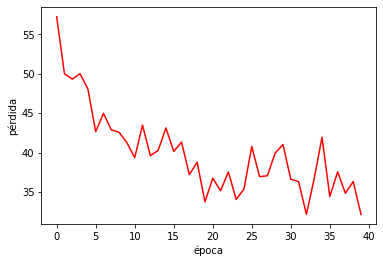

In [ ]:
plt.plot(loss_hist, color='red')
plt.xlabel('época')
plt.ylabel('pérdida')
plt.show()

Notemos que a pesar de tener una función de pérdida más baja, esta misma es mucho más ruidosa.

In [ ]:
model = MLP()

# optimizador
opt = optim.Adam(model.parameters(), lr=1e-4)
# historial de pérdida
loss_hist = []

# ciclo de entrenamiento
EPOCHS = 30
for epoch in range(EPOCHS):
    
    # entrenamiento de una época
    for x, y_true in trn_dl:
        # vaciamos los gradientes
        opt.zero_grad()
        # hacemos inferencia para obtener los logits
        y_lgts = model(x)
        # calculamos la pérdida
        loss = F.cross_entropy(y_lgts, y_true)
        # retropropagamos
        loss.backward()
        # actulizamos parámetros
        opt.step()

    # evitamos que se registren las operaciones 
    # en la gráfica de cómputo
    with torch.no_grad(): 
        # modelo en modo de evaluación
        model.eval()
        
        losses, accs = [], []
        # validación de la época
        for x, y_true in take(tst_dl, 10):
            # hacemos inferencia para obtener los logits
            y_lgts = model(x)
            # calculamos las probabilidades
            y_prob = F.softmax(y_lgts, 1)
            # obtenemos la clase predicha
            y_pred = torch.argmax(y_prob, 1)
            
            # calculamos la pérdida
            loss = F.cross_entropy(y_lgts, y_true)
            # calculamos la exactitud
            acc = (y_true == y_pred).type(torch.float32).mean()

            # guardamos históricos
            losses.append(loss.item() * 100)
            accs.append(acc.item() * 100)

        # imprimimos métricas
        loss = np.mean(losses)
        acc = np.mean(accs)
        print(f'E{epoch:2} loss={loss:6.2f} acc={acc:.2f}')
        
        # agregagmos al historial de pérdidas
        loss_hist.append(loss)
        
        # modelo en modo de entrenamiento
        model.train()

E 0 loss= 55.95 acc=80.16
E 1 loss= 49.52 acc=82.27
E 2 loss= 44.31 acc=84.22
E 3 loss= 42.92 acc=84.61
E 4 loss= 41.96 acc=84.69
E 5 loss= 45.61 acc=83.28
E 6 loss= 39.11 acc=86.80
E 7 loss= 41.07 acc=85.31
E 8 loss= 39.99 acc=85.94
E 9 loss= 39.77 acc=86.80
E10 loss= 38.10 acc=86.80
E11 loss= 37.49 acc=86.09
E12 loss= 35.02 acc=87.66
E13 loss= 39.50 acc=84.84
E14 loss= 37.38 acc=86.33
E15 loss= 30.92 acc=88.44
E16 loss= 34.85 acc=87.11
E17 loss= 32.31 acc=88.44
E18 loss= 33.77 acc=88.05
E19 loss= 35.26 acc=86.33
E20 loss= 37.21 acc=86.25
E21 loss= 32.42 acc=88.12
E22 loss= 37.76 acc=87.19
E23 loss= 35.43 acc=87.73
E24 loss= 31.44 acc=88.20
E25 loss= 30.03 acc=89.14
E26 loss= 37.00 acc=87.19
E27 loss= 34.00 acc=87.11
E28 loss= 30.76 acc=88.12
E29 loss= 33.66 acc=88.12


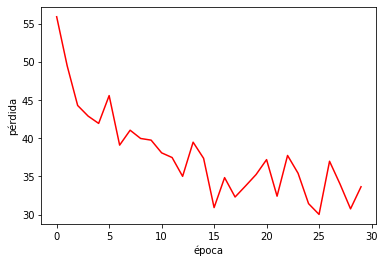

In [ ]:
plt.plot(loss_hist, color='red')
plt.xlabel('época')
plt.ylabel('pérdida')
plt.show()

Ahora bien, cambiando el optimizador por Adam, notamos que tenemos un descenso un poco ruidoso, pero la pérdida es más baja, por lo que incita a dejarlo más épocas. Antes de eso cambiaremos la arquitectura.

Para la nueva arquitectura se propone:


```
nn.Sequential(
            # fc1
            # [N, 1x28x28] => [N, 128]
            
            nn.Linear(self.I, FC1),
            nn.Linear(FC1, 64),
            nn.Linear(64, 32),
            nn.ReLU(),
            # fc2
            # [N, 128] => [N, 10]
            nn.Linear(32, FC2)
        )
```
La cual consiste en dos capas lineales ocultas de 64 y 32 neuronas



In [ ]:
class MLP2(nn.Module):
    
    # inicializador
    def __init__(self):
        # inicilización del objeto padre, obligatorio
        super(MLP2, self).__init__()
        # tamaño de las capas
        self.I = 1 * 28 * 28
        FC1, FC2 = 128, 10
        # definición de capas
        self.cls = nn.Sequential(
            # fc1
            # [N, 1x28x28] => [N, 128]
            
            nn.Linear(self.I, FC1),
            nn.Linear(FC1, 64),
            nn.Linear(64, 32),
            nn.ReLU(),
            # fc2
            # [N, 128] => [N, 10]
            nn.Linear(32, FC2)
        )
    
    # metodo para inferencia
    def forward(self, x):
        # aplanamos los pixeles de la imagen
        # [N, 1, 28, 28] => [N, 1x28x28]
        x = x.view(-1, self.I)
        # inferencia
        # [N, 1x28x28]
        x = self.cls(x)
        return x


model=MLP2()


# optimizador
opt = optim.Adam(model.parameters(), lr=1e-3)
# historial de pérdida
loss_hist = []

# ciclo de entrenamiento
EPOCHS = 30
for epoch in range(EPOCHS):
    
    # entrenamiento de una época
    for x, y_true in trn_dl:
        # vaciamos los gradientes
        opt.zero_grad()
        # hacemos inferencia para obtener los logits
        y_lgts = model(x)
        # calculamos la pérdida
        loss = F.cross_entropy(y_lgts, y_true)
        # retropropagamos
        loss.backward()
        # actulizamos parámetros
        opt.step()

    # evitamos que se registren las operaciones 
    # en la gráfica de cómputo
    with torch.no_grad(): 
        # modelo en modo de evaluación
        model.eval()
        
        losses, accs = [], []
        # validación de la época
        for x, y_true in take(tst_dl, 10):
            # hacemos inferencia para obtener los logits
            y_lgts = model(x)
            # calculamos las probabilidades
            y_prob = F.softmax(y_lgts, 1)
            # obtenemos la clase predicha
            y_pred = torch.argmax(y_prob, 1)
            
            # calculamos la pérdida
            loss = F.cross_entropy(y_lgts, y_true)
            # calculamos la exactitud
            acc = (y_true == y_pred).type(torch.float32).mean()

            # guardamos históricos
            losses.append(loss.item() * 100)
            accs.append(acc.item() * 100)

        # imprimimos métricas
        loss = np.mean(losses)
        acc = np.mean(accs)
        print(f'E{epoch:2} loss={loss:6.2f} acc={acc:.2f}')
        
        # agregagmos al historial de pérdidas
        loss_hist.append(loss)
        
        # modelo en modo de entrenamiento
        model.train()

E 0 loss= 45.58 acc=83.91
E 1 loss= 45.36 acc=84.45
E 2 loss= 42.77 acc=84.61
E 3 loss= 41.80 acc=84.06
E 4 loss= 35.66 acc=87.58
E 5 loss= 39.49 acc=85.47
E 6 loss= 41.37 acc=85.00
E 7 loss= 41.77 acc=85.94
E 8 loss= 32.94 acc=87.50
E 9 loss= 46.35 acc=83.36
E10 loss= 39.71 acc=86.88
E11 loss= 32.49 acc=88.59
E12 loss= 39.78 acc=86.25
E13 loss= 39.10 acc=86.88
E14 loss= 33.94 acc=88.75
E15 loss= 38.64 acc=87.11
E16 loss= 39.32 acc=86.56
E17 loss= 33.61 acc=89.53
E18 loss= 35.15 acc=87.73
E19 loss= 40.16 acc=86.95
E20 loss= 39.67 acc=86.64
E21 loss= 38.67 acc=87.89
E22 loss= 37.74 acc=87.73
E23 loss= 34.32 acc=88.20
E24 loss= 38.48 acc=87.58
E25 loss= 40.25 acc=86.80
E26 loss= 37.61 acc=86.95
E27 loss= 42.36 acc=87.11
E28 loss= 34.22 acc=87.81
E29 loss= 44.72 acc=85.00


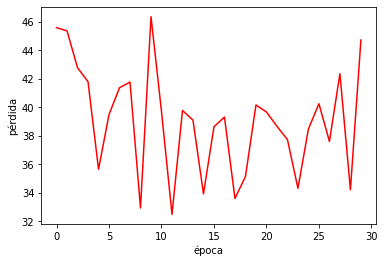

In [ ]:
plt.plot(loss_hist, color='red')
plt.xlabel('época')
plt.ylabel('pérdida')
plt.show()

La nueva arquitectura tiee un gráfica de pérdida muy fluctuante, reduciremos el lr y esperamos sea más suave

In [ ]:

model=MLP2()


# optimizador
opt = optim.Adam(model.parameters(), lr=1e-5)
# historial de pérdida
loss_hist = []

# ciclo de entrenamiento
EPOCHS = 30
for epoch in range(EPOCHS):
    
    # entrenamiento de una época
    for x, y_true in trn_dl:
        # vaciamos los gradientes
        opt.zero_grad()
        # hacemos inferencia para obtener los logits
        y_lgts = model(x)
        # calculamos la pérdida
        loss = F.cross_entropy(y_lgts, y_true)
        # retropropagamos
        loss.backward()
        # actulizamos parámetros
        opt.step()

    # evitamos que se registren las operaciones 
    # en la gráfica de cómputo
    with torch.no_grad(): 
        # modelo en modo de evaluación
        model.eval()
        
        losses, accs = [], []
        # validación de la época
        for x, y_true in take(tst_dl, 10):
            # hacemos inferencia para obtener los logits
            y_lgts = model(x)
            # calculamos las probabilidades
            y_prob = F.softmax(y_lgts, 1)
            # obtenemos la clase predicha
            y_pred = torch.argmax(y_prob, 1)
            
            # calculamos la pérdida
            loss = F.cross_entropy(y_lgts, y_true)
            # calculamos la exactitud
            acc = (y_true == y_pred).type(torch.float32).mean()

            # guardamos históricos
            losses.append(loss.item() * 100)
            accs.append(acc.item() * 100)

        # imprimimos métricas
        loss = np.mean(losses)
        acc = np.mean(accs)
        print(f'E{epoch:2} loss={loss:6.2f} acc={acc:.2f}')
        
        # agregagmos al historial de pérdidas
        loss_hist.append(loss)
        
        # modelo en modo de entrenamiento
        model.train()

E 0 loss=161.56 acc=54.14
E 1 loss=115.63 acc=63.28
E 2 loss= 91.64 acc=70.31
E 3 loss= 80.03 acc=72.73
E 4 loss= 75.03 acc=74.38
E 5 loss= 70.06 acc=76.72
E 6 loss= 67.02 acc=76.64
E 7 loss= 62.39 acc=78.20
E 8 loss= 59.84 acc=79.30
E 9 loss= 62.08 acc=78.36
E10 loss= 58.94 acc=78.36
E11 loss= 59.14 acc=80.78
E12 loss= 53.31 acc=81.64
E13 loss= 51.56 acc=81.33
E14 loss= 57.27 acc=80.08
E15 loss= 50.10 acc=82.19
E16 loss= 51.35 acc=82.19
E17 loss= 50.94 acc=81.72
E18 loss= 51.76 acc=81.56
E19 loss= 47.92 acc=83.52
E20 loss= 51.09 acc=81.95
E21 loss= 47.76 acc=84.14
E22 loss= 47.85 acc=83.12
E23 loss= 52.37 acc=81.33
E24 loss= 51.23 acc=81.02
E25 loss= 49.33 acc=82.66
E26 loss= 45.11 acc=84.45
E27 loss= 45.09 acc=83.83
E28 loss= 45.74 acc=83.91
E29 loss= 48.69 acc=83.98


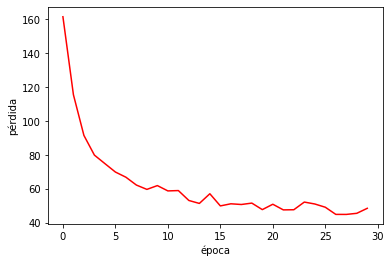

In [ ]:
plt.plot(loss_hist, color='red')
plt.xlabel('época')
plt.ylabel('pérdida')
plt.show()

Probaremos con un optimizador distinto


In [ ]:

model=MLP2()


# optimizador
opt = optim.SGD(model.parameters(), lr=1e-2)
# historial de pérdida
loss_hist = []

# ciclo de entrenamiento
EPOCHS = 30
for epoch in range(EPOCHS):
    
    # entrenamiento de una época
    for x, y_true in trn_dl:
        # vaciamos los gradientes
        opt.zero_grad()
        # hacemos inferencia para obtener los logits
        y_lgts = model(x)
        # calculamos la pérdida
        loss = F.cross_entropy(y_lgts, y_true)
        # retropropagamos
        loss.backward()
        # actulizamos parámetros
        opt.step()

    # evitamos que se registren las operaciones 
    # en la gráfica de cómputo
    with torch.no_grad(): 
        # modelo en modo de evaluación
        model.eval()
        
        losses, accs = [], []
        # validación de la época
        for x, y_true in take(tst_dl, 10):
            # hacemos inferencia para obtener los logits
            y_lgts = model(x)
            # calculamos las probabilidades
            y_prob = F.softmax(y_lgts, 1)
            # obtenemos la clase predicha
            y_pred = torch.argmax(y_prob, 1)
            
            # calculamos la pérdida
            loss = F.cross_entropy(y_lgts, y_true)
            # calculamos la exactitud
            acc = (y_true == y_pred).type(torch.float32).mean()

            # guardamos históricos
            losses.append(loss.item() * 100)
            accs.append(acc.item() * 100)

        # imprimimos métricas
        loss = np.mean(losses)
        acc = np.mean(accs)
        print(f'E{epoch:2} loss={loss:6.2f} acc={acc:.2f}')
        
        # agregagmos al historial de pérdidas
        loss_hist.append(loss)
        
        # modelo en modo de entrenamiento
        model.train()

E 0 loss= 75.91 acc=72.42
E 1 loss= 61.85 acc=77.27
E 2 loss= 52.74 acc=82.19
E 3 loss= 49.04 acc=82.66
E 4 loss= 52.71 acc=80.47
E 5 loss= 44.55 acc=84.77
E 6 loss= 47.57 acc=83.36
E 7 loss= 44.83 acc=83.52
E 8 loss= 43.56 acc=84.69
E 9 loss= 47.91 acc=83.36
E10 loss= 49.58 acc=81.80
E11 loss= 46.08 acc=83.75
E12 loss= 45.84 acc=84.06
E13 loss= 47.89 acc=84.14
E14 loss= 40.39 acc=85.47
E15 loss= 42.97 acc=85.47
E16 loss= 41.06 acc=85.08
E17 loss= 39.59 acc=86.72
E18 loss= 41.74 acc=85.62
E19 loss= 42.01 acc=85.00
E20 loss= 42.84 acc=84.77
E21 loss= 43.25 acc=85.31
E22 loss= 40.16 acc=85.70
E23 loss= 41.93 acc=83.98
E24 loss= 44.04 acc=84.53
E25 loss= 43.01 acc=85.16
E26 loss= 40.92 acc=85.00
E27 loss= 42.17 acc=85.00
E28 loss= 39.80 acc=85.23
E29 loss= 39.00 acc=86.56


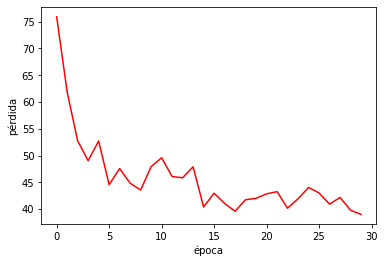

In [ ]:
plt.plot(loss_hist, color='red')
plt.xlabel('época')
plt.ylabel('pérdida')
plt.show()

Procederemos a realizar la validación con este ultimo modelo, con el fin de utilizar una arquitectura distinta.

### Validación

In [ ]:
# modelo en modo de evaluación
model.eval()

# evitamos que se registren las operaciones 
# en la gráfica de cómputo
with torch.no_grad(): 
        
    accs = []
    # validación de la época
    for x, y_true in tst_dl:
        # hacemos inferencia para obtener los logits
        y_lgts = model(x)
        # calculamos las probabilidades
        y_prob = F.softmax(y_lgts, 1)
        # obtenemos la clase predicha
        y_pred = torch.argmax(y_prob, 1)
        
        # calculamos la exactitud
        acc = (y_true == y_pred).type(torch.float32).mean()

        accs.append(acc.item() * 100)

    acc = np.mean(accs)

print(f'Exactitud = {acc:.2f}')

Exactitud = 85.21


### Como podemos ver, tuvo un resultado muy cercano al entrenamiento, por lo que podríamos decir que es un modelo bien ajustado.

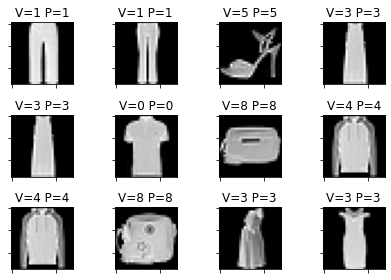

In [ ]:
with torch.no_grad(): 
    for x, y_true in take(tst_dl, 1):
        y_lgts = model(x)
        y_prob = F.softmax(y_lgts, 1)
        y_pred = torch.argmax(y_prob, 1)

    x = x[:12].squeeze().numpy()
    y_true = y_true[:12].numpy()
    y_pred = y_pred[:12].numpy()

titles = [f'V={t} P={p}' for t, p in zip(y_true, y_pred)]
display_grid(x, titles, 3, 4)

### Conclusión

Para finalizar, en esta tarea aprendí a crear una pequeña red para la compuerta XNOR la cual podría no conciderarse como que aprendíó ya que friamente sólo selecconé los pesos, se hizo la suma pesada y listo, pero la justificación es que para funciones así de simples, no está mal. Como segundo ejercicio ahora sí aprendió la red, después de cierto número de iteraciones (bastantes a mi parecer) logramos que aprendiera la función con una exactitud de 100% (lo necesario y justo para una función tan básica) sin embargo, en las tareas posteriores esto ya fue más complejo.

El último ejercicio fue el más interesante debido a la complejidad de clasificar las 10 clases, sin embargo al hacer las iteraciones logré apreciar ciertos comportamientos, por ejemplo, al bajar el learning rate, la función de pérdida se vuelve más suave, esto es porque los "saltos" son muy pequeños, así cada salida es muy parecida a la anterior, caso contrario al aumentar el learning rate, si bien, llegabamos más rápido al mínimo, la gráfica era bastante ruidosa, esto por los saltos tan granes que daba. ¿por qué no elegí un learning rate grande si tenía mejor pérdida? pues porque el hecho de que tuviera altibajos tan marcados lo hacía muy sensible a que la época final quedara en un pico alto, de esta manera podíamos obtener una peor evaluación. Es por eso que elegí la más confiable. Me hubiese gustado hacer más épocas para encontrar el número correcto, sin embargo era algo tardado, pese a esto considero que mi modelo con un acc = 87.86 en validación (jamás se vio, hasta que se ejecutó una única ves= es bastante bueno.